# Learning how to build deep neural nets
## Based on Chap 10 of Hands on ML 3rd ed

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
np.random.seed(0)
import matplotlib as mpl
import matplotlib.pyplot as plt

### List of initializer functions, glorot_uniform is usually the default.
### He initializer is also one that works well with Relu

In [3]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

In [6]:
# To get He initializer with uniform distribution but based on fan_avg rather than fan_in
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

### List of activation functions

In [7]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

1. Sigmoid function is in biological neurons but lead to exploding and vanishing gradients so sometimes ReLU is better.
2. Drawback of ReLU - dying neurons, stop outputting anything other than zero
3. To solve this - leaky ReLU = max(\alpha z , z) alpha usually set to 0.01
4. Newer paper used something called exponential linear unit (ELU) - slower to compute
5. 2017 - Scaled ELU (SELU). Exclusively a stack of dense layers which self normalize. Initialization with lecun_normal. Architecture must be sequential, can improve CNN's as well

In [8]:
# Can't set as activation directly 
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

### Try to train fashion MNIST using Leaky ReLU

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [11]:
tf.random.set_seed(0)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    # Have to use this additional layer after each layer
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])


In [13]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 100us/sample - loss: 1.2530 - accuracy: 0.6110 - val_loss: 0.8560 - val_accuracy: 0.7272
Epoch 2/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.7813 - accuracy: 0.7411 - val_loss: 0.6964 - val_accuracy: 0.7694
Epoch 3/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.6735 - accuracy: 0.7742 - val_loss: 0.6251 - val_accuracy: 0.7982
Epoch 4/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.6162 - accuracy: 0.7950 - val_loss: 0.5851 - val_accuracy: 0.8056
Epoch 5/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.5788 - accuracy: 0.8086 - val_loss: 0.5528 - val_accuracy: 0.8180
Epoch 6/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.5523 - accuracy: 0.8160 - val_loss: 0.5279 - val_accuracy: 0.8272
Epoch 7/10
55000/55000 [==============================] 

### Training using SELU
In this case need to scale to mean 0 and SD 1

In [8]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
# Much slower but avoids vanishing or exploding gradient problem
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 53s 961us/sample - loss: 1.2577 - accuracy: 0.5144 - val_loss: 0.9184 - val_accuracy: 0.6616
Epoch 2/5
55000/55000 [==============================] - 45s 825us/sample - loss: 0.8798 - accuracy: 0.6705 - val_loss: 1.6595 - val_accuracy: 0.2790
Epoch 3/5
55000/55000 [==============================] - 45s 823us/sample - loss: 0.9829 - accuracy: 0.6283 - val_loss: 0.7660 - val_accuracy: 0.7002
Epoch 4/5
55000/55000 [==============================] - 46s 836us/sample - loss: 0.7512 - accuracy: 0.7079 - val_loss: 0.6577 - val_accuracy: 0.7442
Epoch 5/5
55000/55000 [==============================] - 45s 816us/sample - loss: 0.6259 - accuracy: 0.7650 - val_loss: 0.5664 - val_accuracy: 0.7994


### Batch normalization
1. Adding an operation just before activation to zero center and normalize each input. 
2. Can add at the start too, then won't require scaling variables (normalizes each batch btw not the whole dataset)
3. Instead of doing normalization each time, keras uses a moving average of layers means and SDs
4. Using batch normalization helps with vanishing gradients problem, so can use tanh and sigmoid activation too
5. Also acts as a regularizer, reducing need for other regularizers like dropout
6. Faster convergence

In [3]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [5]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [6]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 11s 207us/sample - loss: 0.8603 - accuracy: 0.7109 - val_loss: 0.5515 - val_accuracy: 0.8180
Epoch 2/10
55000/55000 [==============================] - 10s 191us/sample - loss: 0.5737 - accuracy: 0.8017 - val_loss: 0.4728 - val_accuracy: 0.8400
Epoch 3/10
55000/55000 [==============================] - 10s 184us/sample - loss: 0.5144 - accuracy: 0.8215 - val_loss: 0.4359 - val_accuracy: 0.8540
Epoch 4/10
55000/55000 [==============================] - 10s 185us/sample - loss: 0.4791 - accuracy: 0.8335 - val_loss: 0.4153 - val_accuracy: 0.8588
Epoch 5/10
55000/55000 [==============================] - 12s 211us/sample - loss: 0.4580 - accuracy: 0.8388 - val_loss: 0.4013 - val_accuracy: 0.8642
Epoch 6/10
55000/55000 [==============================] - 11s 196us/sample - loss: 0.4363 - accuracy: 0.8480 - val_loss: 0.3904 - val_accuracy: 0.8640
Epoch 7/10
55000/55000 [=====================

Layer before a batch normalization doesn't need bias terms (waste of space since BN does it automatically) 
So can do something like this

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [9]:

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 18s 332us/sample - loss: 1.0344 - accuracy: 0.6736 - val_loss: 0.6724 - val_accuracy: 0.7922
Epoch 2/10
55000/55000 [==============================] - 16s 287us/sample - loss: 0.6782 - accuracy: 0.7827 - val_loss: 0.5544 - val_accuracy: 0.8228
Epoch 3/10
55000/55000 [==============================] - 15s 281us/sample - loss: 0.5910 - accuracy: 0.8052 - val_loss: 0.4973 - val_accuracy: 0.8388
Epoch 4/10
55000/55000 [==============================] - 15s 277us/sample - loss: 0.5440 - accuracy: 0.8173 - val_loss: 0.4638 - val_accuracy: 0.8458
Epoch 5/10
55000/55000 [==============================] - 15s 267us/sample - loss: 0.5093 - accuracy: 0.8277 - val_loss: 0.4418 - val_accuracy: 0.8532
Epoch 6/10
55000/55000 [==============================] - 14s 258us/sample - loss: 0.4899 - accuracy: 0.8325 - val_loss: 0.4234 - val_accuracy: 0.8582
Epoch 7/10
55000/55000 [=====================

# Transfer learning

### Reusing pretrained layers
1. Not a good idea to train very large DNN from scratch
2. Try to find existing NN that accomplishes a similar task and reuse the lower layers
3. Speed up training and need less training data

### Example
1. Use MNIST Fashion with 8 classes except sandal and shirt - someone built a model on it and got 90% accuracy
2. Now use the sandal and shirt data, train binary classifier, small dataset only 200 images, 
3. Task quite similar so transfer learning between the first model to this

In [10]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [11]:
# except sandals and shirt
X_train_A.shape

(43986, 28, 28)

In [13]:
# only sandals and shirt
X_train_B.shape

(200, 28, 28)

In [14]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [15]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [16]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [17]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [18]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 10s 232us/sample - loss: 0.5712 - accuracy: 0.8140 - val_loss: 0.3755 - val_accuracy: 0.8747
Epoch 2/20
43986/43986 [==============================] - 9s 202us/sample - loss: 0.3577 - accuracy: 0.8763 - val_loss: 0.3247 - val_accuracy: 0.8901
Epoch 3/20
43986/43986 [==============================] - 8s 183us/sample - loss: 0.3218 - accuracy: 0.8885 - val_loss: 0.3009 - val_accuracy: 0.8989
Epoch 4/20
43986/43986 [==============================] - 8s 182us/sample - loss: 0.3021 - accuracy: 0.8951 - val_loss: 0.2868 - val_accuracy: 0.9028
Epoch 5/20
43986/43986 [==============================] - 9s 200us/sample - loss: 0.2887 - accuracy: 0.9006 - val_loss: 0.2785 - val_accuracy: 0.9088
Epoch 6/20
43986/43986 [==============================] - 9s 200us/sample - loss: 0.2781 - accuracy: 0.9045 - val_loss: 0.2714 - val_accuracy: 0.9098
Epoch 7/20
43986/43986 [==========================

In [19]:
model_A.save("../models/model_A_TL.h5")

### Try a model with the small training set only 

In [20]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [21]:

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [22]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 2s 9ms/sample - loss: 0.4965 - accuracy: 0.7850 - val_loss: 0.3920 - val_accuracy: 0.8590
Epoch 2/20
200/200 [==============================] - 0s 945us/sample - loss: 0.3490 - accuracy: 0.8650 - val_loss: 0.2931 - val_accuracy: 0.9087
Epoch 3/20
200/200 [==============================] - 0s 932us/sample - loss: 0.2597 - accuracy: 0.9250 - val_loss: 0.2352 - val_accuracy: 0.9422
Epoch 4/20
200/200 [==============================] - 0s 1ms/sample - loss: 0.2058 - accuracy: 0.9650 - val_loss: 0.1982 - val_accuracy: 0.9615
Epoch 5/20
200/200 [==============================] - 0s 858us/sample - loss: 0.1710 - accuracy: 0.9750 - val_loss: 0.1731 - val_accuracy: 0.9645
Epoch 6/20
200/200 [==============================] - 0s 1ms/sample - loss: 0.1462 - accuracy: 0.9850 - val_loss: 0.1528 - val_accuracy: 0.9696
Epoch 7/20
200/200 [==============================] - 0s 1ms/sample - loss: 0.1271 -

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

### What if we use transfer learning

In [26]:
model_A = keras.models.load_model("../models/model_A_TL.h5")
# Use all layers except the last (different shape)
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
# Add in a final layer
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [27]:
# model A and B share layers, changes to model B on A will affect model A too, clone the model to avoid this
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [28]:
# Don't want to train already trained layers from model_A
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [29]:
# Since the new output layer was initialized randomly, will make large errors, so freeze the reused layers during first few epochs 
# gives the new layer time to learn some reasonable weights
# always compile after freeze or unfreeze layers
# After unfreezing, good idea to reduce the learning rate
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-4),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 1s 7ms/sample - loss: 0.0805 - accuracy: 0.9850 - val_loss: 0.0918 - val_accuracy: 0.9868
Epoch 2/4
200/200 [==============================] - 0s 723us/sample - loss: 0.0795 - accuracy: 0.9850 - val_loss: 0.0909 - val_accuracy: 0.9868
Epoch 3/4
200/200 [==============================] - 0s 768us/sample - loss: 0.0786 - accuracy: 0.9850 - val_loss: 0.0899 - val_accuracy: 0.9868
Epoch 4/4
200/200 [==============================] - 0s 952us/sample - loss: 0.0776 - accuracy: 0.9850 - val_loss: 0.0890 - val_accuracy: 0.9868
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 2s 9ms/sample - loss: 0.0768 - accuracy: 0.9850 - val_loss: 0.0884 - val_accuracy: 0.9868
Epoch 2/16
200/200 [==============================] - 0s 1ms/sample - loss: 0.0761 - accuracy: 0.9850 - val_loss: 0.0877 - val_accuracy: 0.9868
Epoch 3/16
200/200 [======================

In [30]:
model_B.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06474531203508377, 0.9885]

In [31]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.08566666263341903, 0.9855]

Note that this is against the trend in the book. He also mentions that "Transfer learning doesn't work well with small, dense networks" (not enough patterns to learn)

Transfer learning works best with deep CNNs

### Faster optimizers than Gradient Descent
1. Momentum optimization (faster or slower based on slope)
   optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
2. Nesterov Accelerated Gradient (variant to momentum, measure gradient slightly ahead in direction of momentum)
    optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
3. AdaGrad - Scales down gradient along the steepest dimensions
    optimizer = keras.optimizers.Adagrad(lr=0.001)
4. RMSProp - Accumulate gradients from the most recent iterations
    optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
5. Adam (adaptive moment estimation), keeps track of exponentially decaying average of past gradients and average of past squared gradients
    2 variants - Adamax (replace l2 norm with max) and Nadam (adam + nesterov)
     optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)
    optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

### Learning rate scheduling

Start with large rate and reduce once training stops making fast progress, or with low and increase.

Different types of schedules

### Power Scheduling
Can use default optimizer

In [3]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

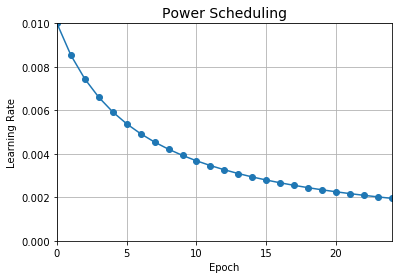

In [5]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_epochs=25
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [9]:
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 7s 122us/sample - loss: 0.4877 - accuracy: 0.8268 - val_loss: 0.4213 - val_accuracy: 0.8558
Epoch 2/25
55000/55000 [==============================] - 5s 92us/sample - loss: 0.3802 - accuracy: 0.8653 - val_loss: 0.3792 - val_accuracy: 0.8688
Epoch 3/25
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3469 - accuracy: 0.8769 - val_loss: 0.3677 - val_accuracy: 0.8718
Epoch 4/25
55000/55000 [==============================] - 5s 91us/sample - loss: 0.3251 - accuracy: 0.8844 - val_loss: 0.3634 - val_accuracy: 0.8710
Epoch 5/25
55000/55000 [==============================] - 5s 94us/sample - loss: 0.3102 - accuracy: 0.8887 - val_loss: 0.3606 - val_accuracy: 0.8750
Epoch 6/25
55000/55000 [==============================] - 5s 94us/sample - loss: 0.2969 - accuracy: 0.8948 - val_loss: 0.3489 - val_accuracy: 0.8782
Epoch 7/25
55000/55000 [==============================] 

### Exponential Scheduling
Define Scheduler

In [10]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [12]:
# Specify as a callback rather than in optimizer
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 10s 181us/sample - loss: 0.8966 - accuracy: 0.7457 - val_loss: 0.7725 - val_accuracy: 0.7212
Epoch 2/25
55000/55000 [==============================] - 9s 156us/sample - loss: 0.8037 - accuracy: 0.7586 - val_loss: 0.8040 - val_accuracy: 0.7676
Epoch 3/25
55000/55000 [==============================] - 8s 152us/sample - loss: 0.6526 - accuracy: 0.8008 - val_loss: 0.7257 - val_accuracy: 0.8082
Epoch 4/25
55000/55000 [==============================] - 9s 167us/sample - loss: 0.6183 - accuracy: 0.8172 - val_loss: 0.6586 - val_accuracy: 0.8288
Epoch 5/25
55000/55000 [==============================] - 9s 155us/sample - loss: 0.5175 - accuracy: 0.8435 - val_loss: 0.6786 - val_accuracy: 0.8228
Epoch 6/25
55000/55000 [==============================] - 9s 156us/sample - loss: 0.4843 - accuracy: 0.8542 - val_loss: 0.5234 - val_accuracy: 0.8548
Epoch 7/25
55000/55000 [==========================

### Piecewise constant scheduling

In [13]:

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

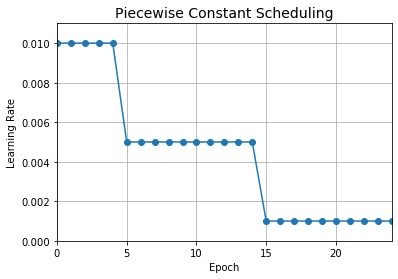

In [14]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance scheduling
Reduce learning rate by factor lambda when error stops dropping

In [15]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.5919 - accuracy: 0.8075 - val_loss: 0.4507 - val_accuracy: 0.8512
Epoch 2/25
55000/55000 [==============================] - 6s 107us/sample - loss: 0.5087 - accuracy: 0.8381 - val_loss: 0.4464 - val_accuracy: 0.8572
Epoch 3/25
55000/55000 [==============================] - 7s 119us/sample - loss: 0.5114 - accuracy: 0.8405 - val_loss: 0.4918 - val_accuracy: 0.8478
Epoch 4/25
55000/55000 [==============================] - 7s 119us/sample - loss: 0.5644 - accuracy: 0.8397 - val_loss: 0.7054 - val_accuracy: 0.8172
Epoch 5/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.5430 - accuracy: 0.8473 - val_loss: 0.5266 - val_accuracy: 0.8424
Epoch 6/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.5252 - accuracy: 0.8502 - val_loss: 0.7276 - val_accuracy: 0.8186
Epoch 7/25
55000/55000 [===========================

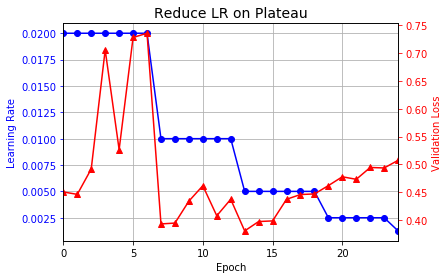

In [16]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
#history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

In [19]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

# Regularization

## l1 and l2 regularization
l1 makes weights zero and l2 makes them multiplied by small constant eg 0.01

In [20]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 10s 178us/sample - loss: 1.6259 - accuracy: 0.8116 - val_loss: 0.7359 - val_accuracy: 0.8296
Epoch 2/2
55000/55000 [==============================] - 9s 163us/sample - loss: 0.7215 - accuracy: 0.8268 - val_loss: 0.7000 - val_accuracy: 0.8340


### looping to write layers using partial

In [23]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 11s 193us/sample - loss: 1.6905 - accuracy: 0.8131 - val_loss: 0.7570 - val_accuracy: 0.8152
Epoch 2/2
55000/55000 [==============================] - 9s 164us/sample - loss: 0.7207 - accuracy: 0.8261 - val_loss: 0.6910 - val_accuracy: 0.8430


## Dropout
### One of the most popular regularization techniques
1. At every step, a neuron has probability p of being temporarily dropped out
2. Dropout rate between 10 and 50 % closer to 20-30 in RNN and 40-50 in CNN.
3. After training, they don't get dropped any more

In [24]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 15s 268us/sample - loss: 0.5748 - accuracy: 0.8019 - val_loss: 0.3779 - val_accuracy: 0.8602
Epoch 2/2
55000/55000 [==============================] - 13s 227us/sample - loss: 0.4246 - accuracy: 0.8464 - val_loss: 0.3479 - val_accuracy: 0.8700


### Alpha dropout
Used in self normalizing networks such as SELU so that mean and SD of inputs are preserved

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 3
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 10s 174us/sample - loss: 0.6679 - accuracy: 0.7571 - val_loss: 0.6186 - val_accuracy: 0.8328
Epoch 2/3
55000/55000 [==============================] - 9s 155us/sample - loss: 0.5526 - accuracy: 0.7974 - val_loss: 0.5121 - val_accuracy: 0.8470
Epoch 3/3
55000/55000 [==============================] - 8s 151us/sample - loss: 0.5274 - accuracy: 0.8034 - val_loss: 0.5416 - val_accuracy: 0.8494
